# Sequence Processing with Recurrent Neural Networks

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies). 

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks are an example of such machinery; for this assignment, you will construct a recurrent neural network that annotates each word of a sentence with a linguistically informative marker. In the simple case (and in this assignment), these markers will be POS tags. However, they can also be other kinds of tags, e.g. more fine-grained morphosyntactic [categories](https://en.wikipedia.org/wiki/Combinatory_categorial_grammar) (supertags).

This task is a case of sequence labeling.  A good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is Alex Graves' [dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand. 

**-------------------------------------------------------------------------------------------------------------**

There are 9 tasks in this assignment for a total of 15 points; tasks 1-2 and 6-9 are worth 2 points each, tasks 3-5 are worth 1 point each.

Make sure to <ins>show the code to your teacher after completing every task</ins>. Don't forget to add comments to your code and self-check frequently by printing data samples, data shapes, etc.

---

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors. 

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs. 
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing. 

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [1]:
import numpy as np
import torch
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional

### Task 1 (2 points): Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [330]:
class mySRN(torch.nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        #
        self.x_to_h = torch.nn.Linear(input_dim, hidden_dim, bias = False)
        self.h_to_h = torch.nn.Linear(hidden_dim, hidden_dim, bias = True)
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim, bias = True)
        self.hidden_actvation = hidden_activation
        self.output_activation = output_activation
        
    def step(self, x: FloatTensor, h: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        # ...
        hidden = self.hidden_activation(self.x_to_h(self.h_to_h(x)))
        y = self.output_activation(self.h_to_y(hidden))
        return hidden, y
        
    def forward(self, X: List[FloatTensor], h: FloatTensor) -> List[FloatTensor]:
        # ...
        h_t = h
        ans = []
        for x in X:
            y, h_t  = self.step(x, h)
            ans.append(y)
        return ans

In [331]:
m = torch.nn.Linear(20, 30, bias = True)
input = torch.randn(128, 20)
output = m(input)
print(output.size())
y

torch.Size([128, 30])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

In practice, we do not need to write our own functions for common RNN architectures. 
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/nn.html#rnn) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

Read the documentation (!) for further details.

A brief example is given below.

In [332]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [333]:
del mySRN, rnn, X, h

### Task 2 (2 points): A faster version of the SRN
Now let's wrap an `RNN` into a custom module `myFastSRN` that implements it aside from the `h_to_y` transformation.

In [6]:
class fastSRN(torch.nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int,
        output_dim: int,
        hidden_activation: str,
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        super(fastSRN, self).__init__() # why?
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.h_to_y = torch.nn.Linear(hidden_dim, output_dim)
        self.device = device
        
    def forward(self, X:FloatTensor, h: Optional[FloatTensor]=None) -> FloatTensor:
        
        if h is not None:
            self.rnn = torch.nn.RNN(input_size=self.input_dim, 
                                    hidden_size=self.hidden_dim, 
                                    nonlinearity=self.hidden_activation, h_0 = h)
        else:
            self.rnn = torch.nn.RNN(input_size=self.input_dim, 
                                    hidden_size=self.hidden_dim, 
                                    nonlinearity=self.hidden_activation)
        H, _ = self.rnn(X)
        
        return self.output_activation(self.h_to_y(H))

Let's see our new implementation in action. 

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [334]:
fast_srn = fastSRN(input_dim = 16, 
                   hidden_dim= 48,
                   output_dim= 2,
                   hidden_activation= 'tanh',
                   output_activation= torch.nn.ReLU(),
                   device = 'cpu')
X = torch.rand(10, 32, 16)
y = fast_srn.forward(X)
y.shape

torch.Size([10, 32, 2])

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

Hopefully everything should be in order.

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [335]:
x_1 = torch.rand(1, 16)  # a sequence of 1, 16-dimensional item
x_2 = torch.rand(7, 16)  # a sequence of 7, 16-dimensional items
x_3 = torch.rand(5, 16)  # a sequence of 5, 16-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x_1, x_2, x_3])  

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([7, 3, 16])


In [336]:
del x_1, x_2, x_3, X

## Pretrained Word Embeddings
Moving on --- in the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).

In [337]:
import spacy

SpaCy comes with a lot of different-size models for different languages. 

We will need to download the small english model for the exercises to follow. You can either do it in a new terminal window (optimal if you are running this assignment through a virtual environment) or by simply running the magic command below. 

In [11]:
# python3 -m spacy download en_core_web_lg

After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [338]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays.

In [13]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
print("We have {} vectors...".format(len(vectors)))
print("...each of shape {}".format(vectors[0].shape))

We have 7 vectors...
...each of shape (300,)


And then finally convert them into torch tensors.

In [14]:
torch_vectors = torch.tensor(vectors)
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [15]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(sentence_vectors), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Task 3 (1 point): Examining the data

First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)


In [16]:
import pickle
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

In [17]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more. 
Run the cell below a couple of times to get an idea of how the data looks like.

In [18]:
import numpy as np
i = np.random.randint(0, len(sentences))
print(list(zip(sentences[i].split(), postags[i])))

[('Financial', 'JJ'), ('printer', 'NN'), ('Bowne', 'NNP'), ('&', 'CC'), ('Co.', 'NNP'), ('said', 'VBD'), ('it', 'PRP'), ('formed', 'VBD'), ('a', 'DT'), ('business', 'NN'), ('translation', 'NN'), ('service', 'NN'), (',', ','), ('which', 'WDT'), ('will', 'MD'), ('provide', 'VB'), ('legal', 'JJ'), (',', ','), ('financial', 'JJ'), ('and', 'CC'), ('other', 'JJ'), ('services', 'NNS'), ('in', 'IN'), ('most', 'JJS'), ('major', 'JJ'), ('languages', 'NNS'), (',', ','), ('including', 'VBG'), ('Japanese', 'NNP'), (',', ','), ('Chinese', 'NNP'), ('and', 'CC'), ('Russian', 'NNP'), ('.', '.')]


The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies. If you are curious, also find out what these tags mean linguisically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

(array([1.08377004e-01, 9.09110677e-02, 9.92625502e-02, 4.02299443e-02,
        1.42927391e-01, 9.25331444e-03, 1.43896364e-03, 2.18728577e-02,
        6.41002605e-02, 1.41409078e-02, 5.17981132e-02, 2.61516001e-02,
        1.44811930e-03, 3.37080666e-02, 3.52050161e-02, 2.45890351e-02,
        4.54913935e-02, 2.52146715e-02, 5.95697377e-02, 2.05239247e-02,
        9.16480979e-03, 1.13133366e-02, 3.03693048e-02, 1.64206657e-02,
        2.88250511e-03, 1.94099868e-03, 2.70396985e-03, 4.38403239e-03,
        3.60732773e-03, 4.37945456e-04, 4.80671842e-04, 2.47507850e-03,
        2.15920843e-03, 7.73652774e-03, 2.99389890e-03, 2.36368471e-03,
        2.76195566e-04, 3.08240356e-04, 1.22533171e-03, 1.06815965e-03,
        1.90742794e-04, 1.72431486e-04, 3.81485589e-05, 1.15971619e-04,
        1.66327717e-04, 1.52594236e-06, 1.22075388e-05, 5.34079824e-05]),
 array([ 0.        ,  0.97916667,  1.95833333,  2.9375    ,  3.91666667,
         4.89583333,  5.875     ,  6.85416667,  7.83333333,  

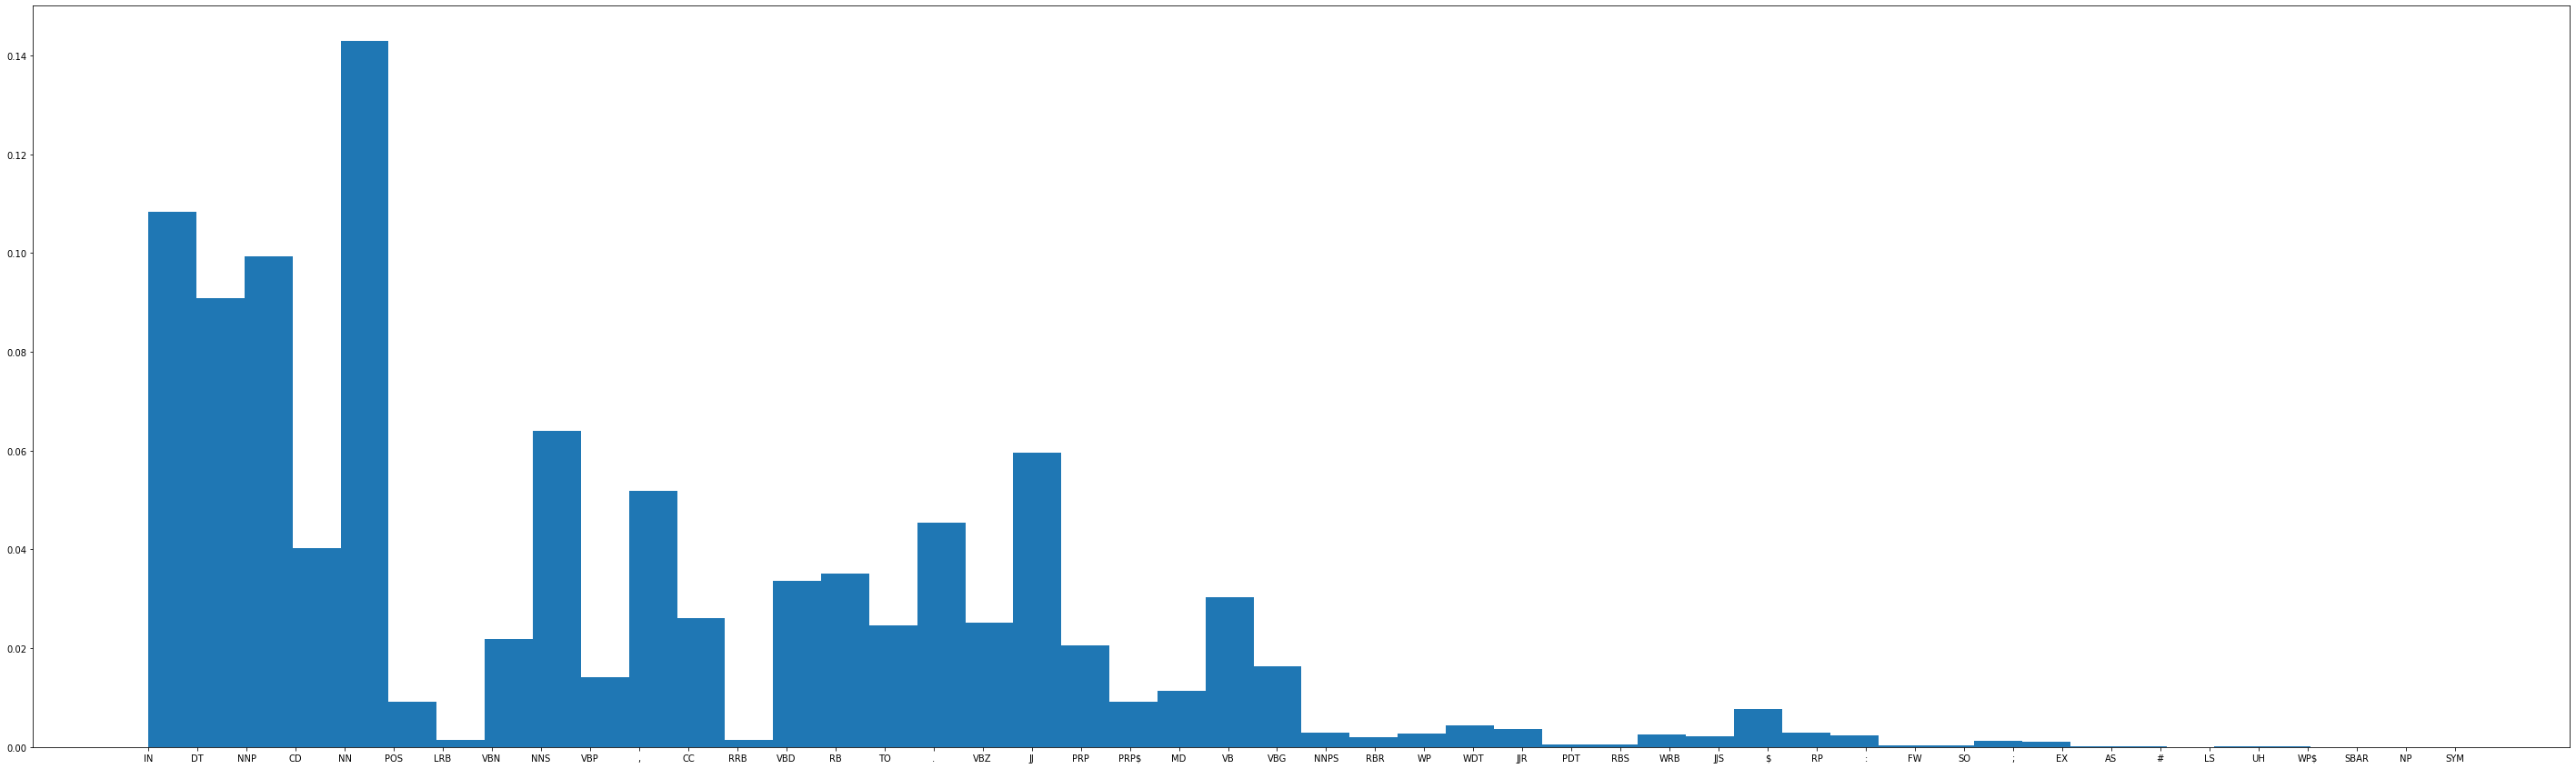

In [19]:
from itertools import chain
onid = list(chain.from_iterable(postags))
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 15))
plt.hist(onid, density = True, bins= 48)

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Task 4 (1 point): Tensorizing sentences
Next, we need to convert our data to numeric form. Convert sentences to their tensor format, as done earlier (this may take a while). 

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized (i.e. they are provided as sequences of words rather than strings), we need to change the processing call to ensure the output vectors are aligned with our tokenization.
</div>

In [20]:
docs = list(map(
    lambda sentence: spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()), 
    sentences
))
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
# Create a blank Tokenizer with just the English vocab
tokenizer = nlp.tokenizer

In [21]:
all_tokens = []
for i in range(len(docs)):
    for token in docs[i]:
        all_tokens.append(token)
        
token_to_int = dict()
m = 0
for token in all_tokens:
    if token not in token_to_int.keys():
        token_to_int.setdefault(str(token), m)
        m += 1
    else:
        continue

In [22]:
token_to_int['In']

0

In [23]:
kk = lambda token_sequence: [token_to_int[token] for token in token_sequence]
docs[0]

In an Oct. 19 review of The Misanthrope at Chicago 's Goodman Theatre -LRB- Revitalized Classics Take the Stage in Windy City , Leisure & Arts -RRB- , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag . 

In [24]:
import torch
from tqdm import tqdm

docs = list(map(nlp, sentences))
doc_vectors = map(lambda doc: [word.vector for word in doc], docs)
doc_tensors = list(map(lambda doc_vectors_sequence: torch.tensor(doc_vectors_sequence), doc_vectors))

print(doc_tensors[0].shape)
print(doc_tensors[0])

torch.Size([45, 300])
tensor([[ 0.0892,  0.2579,  0.2628,  ...,  0.1442, -0.1690,  0.2650],
        [-0.0117,  0.1948,  0.0889,  ..., -0.0547, -0.1934,  0.1400],
        [-0.1505, -0.1601,  0.2423,  ...,  0.8117, -0.1359,  1.1897],
        ...,
        [-0.4646,  0.7281,  0.2261,  ..., -0.6087, -0.3987, -0.0845],
        [ 0.3048,  0.1488,  0.4392,  ...,  0.0393, -0.5180, -0.1768],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350]])


In [339]:
sentences[0]

"In an Oct. 19 review of The Misanthrope at Chicago 's Goodman Theatre -LRB- Revitalized Classics Take the Stage in Windy City , Leisure & Arts -RRB- , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag ."

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [170]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] - 1 for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))
print(pos_tensors[0].shape)
print(pos_tensors[0])

torch.Size([45])
tensor([21,  6, 11,  0, 24, 21,  6, 24, 21, 11, 16, 11, 11, 14, 15, 31,  1,  6,
        24, 21, 11, 11, 28, 24, 32, 31,  7, 28,  6, 24, 21, 11, 28, 15, 21, 11,
        11, 28, 22, 40, 15, 35, 11, 11, 13])


In [171]:
pos_to_int

{'CD': 1,
 'VBP': 2,
 '#': 3,
 'RBS': 18,
 'RP': 4,
 'SBAR': 42,
 '$': 5,
 'WDT': 6,
 'DT': 7,
 'RRB': 8,
 'EX': 10,
 'JJS': 11,
 'LS': 44,
 'NNP': 12,
 '.': 14,
 'LRB': 15,
 'VBN': 16,
 'POS': 17,
 'AS': 19,
 'VB': 20,
 'PRP$': 21,
 'IN': 22,
 'UH': 46,
 'VBZ': 26,
 'VBD': 23,
 'PDT': 24,
 'NN': 25,
 'SYM': 13,
 'NNPS': 27,
 'RBR': 28,
 ',': 29,
 'WRB': 31,
 'NNS': 32,
 'PRP': 34,
 'CC': 33,
 'VBG': 30,
 ':': 35,
 'TO': 36,
 'FW': 37,
 'JJ': 38,
 'NP': 39,
 'WP$': 40,
 'RB': 41,
 ';': 43,
 'MD': 45,
 'JJR': 47,
 'WP': 48,
 'SO': 9}

In [172]:
del doc_vectors, docs, pos_numeric

NameError: name 'doc_vectors' is not defined

In the tutorial, we saw how to split our dataset into a training and a validation set. 

Do the same here, splitting the sentences, postags and their corresponding tensors into a training and a validation set.

In [173]:
len(postags)

30197

In [174]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val = \
train_test_split(sentences, postags, test_size=0.33, random_state=42)
X_train, X_val, Y_train, Y_val = \
train_test_split(doc_tensors, pos_tensors, test_size=0.33, random_state=42)

assert len(X_train) == len(Y_train) == len(sentences_train)
assert len(X_val) == len(Y_val) == len(sentences_val)

In [279]:
for i in range(len(X_train)):
    if X_train[i].size()[0] != Y_train[i].size()[0]:
        print(X_train[i].size(), Y_train[i].size())

torch.Size([34, 300]) torch.Size([32])
torch.Size([38, 300]) torch.Size([36])
torch.Size([49, 300]) torch.Size([47])
torch.Size([29, 300]) torch.Size([25])
torch.Size([30, 300]) torch.Size([28])
torch.Size([32, 300]) torch.Size([30])
torch.Size([34, 300]) torch.Size([32])
torch.Size([37, 300]) torch.Size([35])
torch.Size([23, 300]) torch.Size([19])
torch.Size([21, 300]) torch.Size([19])
torch.Size([22, 300]) torch.Size([20])
torch.Size([27, 300]) torch.Size([25])
torch.Size([48, 300]) torch.Size([46])
torch.Size([36, 300]) torch.Size([34])
torch.Size([27, 300]) torch.Size([25])
torch.Size([30, 300]) torch.Size([28])
torch.Size([34, 300]) torch.Size([32])
torch.Size([31, 300]) torch.Size([29])
torch.Size([38, 300]) torch.Size([36])
torch.Size([39, 300]) torch.Size([37])
torch.Size([31, 300]) torch.Size([29])
torch.Size([34, 300]) torch.Size([32])
torch.Size([32, 300]) torch.Size([30])
torch.Size([33, 300]) torch.Size([31])
torch.Size([39, 300]) torch.Size([35])
torch.Size([35, 300]) tor

In [278]:
X_train[0]

tensor([[ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        [-0.1957,  0.0563, -0.0965,  ..., -0.5051,  0.2706, -0.1133],
        [-0.2677,  0.1780, -0.2635,  ..., -0.4779,  0.1801, -0.1922],
        ...,
        [-0.6824,  0.1774,  0.2385,  ..., -0.0626,  0.1545, -0.4020],
        [ 0.1113, -0.3562,  0.8055,  ..., -0.1181, -0.0443,  0.3897],
        [ 0.0120,  0.2075, -0.1258,  ...,  0.1387, -0.3605, -0.0350]])

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Task 5 (1 point): Datasets and Padding

Again, following along the tutorial, we will wrap our tensors into a `Dataset` and a `DataLoader`.

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

<div class="alert alert-block alert-info">
If you have no experience creating container-like classes from scratch in Python, refer to the documentation for the <a href="https://docs.python.org/3/reference/datamodel.html#special-method-names">special class methods</a> and for <a href="https://docs.python.org/3/reference/datamodel.html#emulating-container-types">emulating container types</a>. Talk to your teacher if needed.</div>

Then, complete the function `pad_batch` which takes a list of 
(x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [282]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import trange

class UnevenLengthDataset(Dataset):
    def __init__(self, X, Y) -> None:
        super(UnevenLengthDataset, self).__init__()
        self.X = X
        self.Y = Y
        
    def __len__(self) -> int:
        return(len(self.X))
        
    def __getitem__(self, idx: int):
        return self.X[idx], self.Y[idx]
    
def pad_batch(batch):
    ansx = []
    ansy = []
    max_length = max(list(map(lambda X: len(X[0]), batch)))
    for i in range(len(batch)):
        if batch[i][0].size()[0] == batch[i][1].size()[0]:
            ansx.append(batch[i][0])
            ansy.append(batch[i][1])
    return (pad_sequence(ansx), pad_sequence(ansy))



    
        
train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset, 
    collate_fn=pad_batch,
    shuffle=True,
    batch_size=32
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=32
)

In [340]:
train_features, train_labels = next(iter(train_dataloader))
train_features.size(), train_labels.size()

(torch.Size([46, 32, 300]), torch.Size([46, 32]))

In [284]:
train_features.size()

torch.Size([31, 32, 300])

What does a batch look like, shape-wise? Use the `train_dataloader` to find out.

In [285]:
# Your code here
train_dataloader

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

So far so good. On to the network.

### Task 6 (2 points): Utility Functions
Remember how we defined our training and validation functions in the tutorial?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor. 

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you. 

In [286]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.
        
    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return: the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.
    
    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return: the network's accuracy
    """13
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy across all batches.
    acc = correct/total
    return acc

Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [321]:
def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],  
    optimizer: torch.optim.Optimizer
) -> float:
    network.train()
    # Train.
    prediction_batch = network(X_batch)  # forward pass
    x = prediction_batch.view(Y_batch.view(-1).size()[0], -1) #flatten
    y = Y_batch.view(-1)
    batch_loss = loss_fn(x, y)  # loss calculation
    batch_loss.backward()  # gradient computation
    optimizer.step()  # back-propagation
    optimizer.zero_grad()  # gradient reset

    return batch_loss.item()
    

def train_epoch(
    network: torch.nn.Module, 
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer, 
    device: str
) -> float:
    loss = 0.
    # Iterate over the batches in the dataloader.
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)  # convert back to your chosen device
        y_batch = y_batch.to(device)
        loss += train_batch(
            network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn, optimizer=optimizer
        )
    loss /= (i+1) # divide the loss by the number of batches for consistency 
    return loss

def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float:
    network.eval()
    prediction_batch = network(X_batch)  # forward pass
    batch_loss = loss_fn(prediction_batch.view(-1), Y_batch)  # loss calculation
    return batch_loss.item()

def eval_epoch(
    network: torch.nn.Module, 
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: 
    return measure_accuracy(network, dataloader, device)


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Task 7 (2 points): SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1) and a hidden size of your own choice.

Use `"tanh"` as your hidden layer activation, and choose **an appropriate combination of output activation and loss function** (consider the task at hand and refer to the documentation or the tutorial if in doubt).

Then instantiate an optimizer over your network and train the network for a number of epochs, measuring and printing all metrics in the process (train and validation loss and accuracy).

_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy.

Plot the loss and accuracy curves over the training process.

In [342]:
from torch.autograd import Variable
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.layer_dim = layer_dim
        # RNN
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')
        # Readout layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, :, :])
        return torch.nn.Softmax(dim = 1)(out)
    
srn = RNNModel(input_dim = 300,
        hidden_dim = 500,
        layer_dim = 2,
        output_dim = 48) #postags
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(srn.parameters(), lr=0.001)

In [343]:
x = x_batch.view(y_batch.view(-1).size()[0], -1)
y = y_batch.view(-1)

In [344]:
x[:, :3]

tensor([[-2.5250e-01, -4.1171e-01, -4.0406e-01],
        [ 8.9187e-02,  2.5792e-01,  2.6282e-01],
        [-2.7523e-01, -3.8723e-01,  3.1627e-01],
        [ 4.7508e-02, -1.2604e-01, -2.0375e-01],
        [ 8.5181e-02,  5.0892e-01, -8.8280e-02],
        [ 1.8733e-01,  4.0595e-01, -5.1174e-01],
        [ 2.7204e-01, -6.2030e-02, -1.8840e-01],
        [-8.2752e-02,  6.7204e-01, -1.4987e-01],
        [ 2.8876e-01, -5.5541e-01,  8.3178e-02],
        [-3.3281e-01, -3.2433e-01,  2.9303e-01],
        [ 2.7204e-01, -6.2030e-02, -1.8840e-01],
        [-2.7903e-01,  7.7040e-01, -1.4395e-01],
        [ 4.9006e-02,  3.8069e-02, -3.7440e-01],
        [-5.1405e-01,  3.1942e-01, -1.0354e-01],
        [ 4.3798e-02,  2.4779e-02, -2.0937e-01],
        [-3.8601e-02,  5.3972e-01, -1.6375e-01],
        [ 8.7460e-03,  3.3214e-01, -2.9175e-01],
        [-5.8041e-02, -4.4507e-02, -1.1891e-01],
        [ 4.3798e-02,  2.4779e-02, -2.0937e-01],
        [ 1.3629e-03,  3.5653e-01, -5.5497e-02],
        [-4.4058e-02

In [345]:
loss = torch.nn.CrossEntropyLoss()
loss(x, y)

tensor(5.7426)

In [346]:

for i, (x_batch, y_batch) in enumerate(train_dataloader):
    x_batch = x_batch.to(device)  # convert back to your chosen device
    y_batch = y_batch.to(device)
    x = srn(x_batch)
    y = y_batch
    if x.size()[0] > y.size()[0]:
        print('shit')
        

In [347]:
# Your training script here
n_epochs = 20
optimizer = opt
model = srn
losses = []
accs = []
device = 'cpu'
for epoch in range(1, n_epochs + 1):
    loss = train_epoch(model, train_dataloader, loss_fn, optimizer, 'cpu')
    acc = eval_epoch(model, train_dataloader, loss_fn, 'cpu')
    losses.append(loss)
    accs.append(acc)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("Loss: {:.4f}".format(loss))

Epoch: 1/20............. Loss: 3.6569
Epoch: 2/20............. Loss: 3.6413
Epoch: 3/20............. Loss: 3.6386
Epoch: 4/20............. Loss: 3.6395
Epoch: 5/20............. Loss: 3.6378
Epoch: 6/20............. Loss: 3.6380
Epoch: 7/20............. Loss: 3.6362
Epoch: 8/20............. Loss: 3.6366
Epoch: 9/20............. Loss: 3.6375
Epoch: 10/20............. Loss: 3.6367
Epoch: 11/20............. Loss: 3.6369
Epoch: 12/20............. Loss: 3.6366
Epoch: 13/20............. Loss: 3.6366
Epoch: 14/20............. Loss: 3.6361
Epoch: 15/20............. Loss: 3.6351
Epoch: 16/20............. Loss: 3.6354
Epoch: 17/20............. Loss: 3.6365
Epoch: 18/20............. Loss: 3.6357
Epoch: 19/20............. Loss: 3.6352
Epoch: 20/20............. Loss: 3.6355


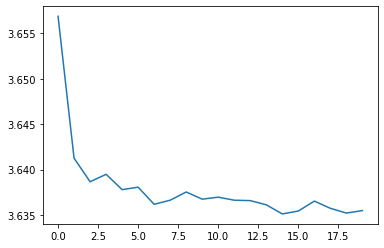

In [348]:
import matplotlib.pyplot
plt.plot(losses)

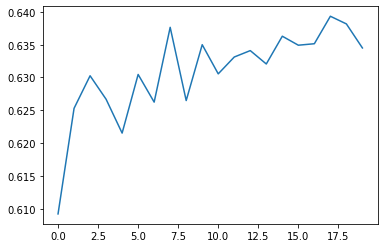

In [349]:
# Your loss plotting here
import matplotlib.pyplot
plt.plot(accs)

In [ ]:
# Your accuracy plotting here

NotImplemented

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, check your code, play with your hyperparameters and try to improve.

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher before proceeding</b>
</div>

### Task 8 (2 points): Error analysis
Find 2-4 sentences where the network predicted wrong POS tags. For at least 2 of the mistakes, make suggestions as to why they were made. Refer to the [documentation](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the POS tag descriptions.

### Task 9 (2 points): Extended error analysis

What are the most commonly confused pairs of POS tags (select the top 3-5 pairs)? Provide illustrations from the data and make suggestions as to why these tag pairs are frequently confused.

### Congratulations!
🎉 You are done with the required part! 

### Optional

RNNs have limited expressive capacity that can be surpassed by more complicated variants such as [Gated Recurrent Units](https://en.wikipedia.org/wiki/Gated_recurrent_unit) and [Long Short-Term Memory Units](https://en.wikipedia.org/wiki/Long_short-term_memory); replacing your RNN with those could easily improve the performance.

If you found the previous part easy and are already done, you can use other neural architectures to do the same task on the same dataset and compare their performance.  (There will be no support provided for this, or points, but you are welcome to explore this for your own understanding :))

Whatever your design choices are, keep the torch documentation close at all times! Do not reinvent the wheel, use existing abstractions whenever possible (but make sure you use them the right way!). Take measures against overfitting: regularize with dropout and/or weight decay and keep track of the validation set performance to stop training early if needed.